# 00-basedata: Get vertices from all espacios públicos in Guadalajara

This iterates over each Polygon / Multipolygon, extracts its vertices and saves them to a new GDF in the database for use in project Volvo.

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/jovyan/accesibilidad-urbana/aup/data.py:25: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


## Load data

In [60]:
# Points of interest - Espacio publico (Parques) ### Exclusive project Volvo
parques_schema = 'espacios_publicos' 
parques_table = 'ep_amg'

# Download parques pois
query = f"SELECT * FROM {parques_schema}.{parques_table}"
gdf = aup.gdf_from_query(query, geometry_col='geometry')

# Show
print(gdf.shape)
gdf.head(2)

(8499, 4)


,Fuente,Tipo,Uso,geometry
0,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672507.028 2272132.201, 672520.126 2..."
1,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672520.126 2272170.353, 672507.028 2..."


<Axes: >

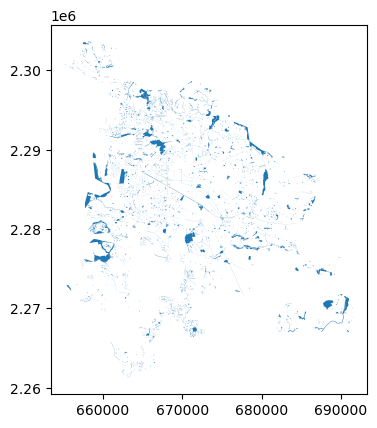

In [61]:
gdf.plot()

## Tests

### Test - Data Filter for Volvo

In [5]:
gdf.Tipo.unique()

array(['Parque', 'Espacio verde vecinal', 'Glorieta', 'Camellón',
       'Área natural', 'Unidad deportiva', 'Plaza',
       'Área natural protegida'], dtype=object)

In [6]:
gdf.Uso.unique()

array(['Uso recreativo', 'Sin uso recreativo'], dtype=object)

In [7]:
tipos = ['Parque','Espacio verde vecinal', 'Plaza', 'Área natural', 'Área natural protegida']

prueba = gdf.loc[gdf.Tipo.isin(tipos)]

# Show
print(prueba.shape)
prueba.head(2)

(3893, 5)


,Fuente,Tipo,Uso,geometry,geom_type
0,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672507.028 2272132.201, 672520.126 2...",Polygon
1,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672520.126 2272170.353, 672507.028 2...",Polygon


<Axes: >

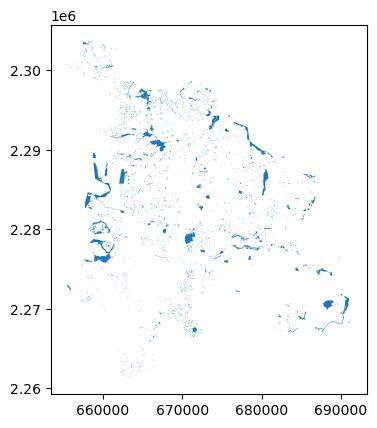

In [10]:
prueba.plot()

In [9]:
prueba2 = prueba.loc[prueba.Uso == 'Uso recreativo']

# Show
print(prueba2.shape)
prueba2.head(2)

(2497, 5)


,Fuente,Tipo,Uso,geometry,geom_type
0,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672507.028 2272132.201, 672520.126 2...",Polygon
1,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672520.126 2272170.353, 672507.028 2...",Polygon


<Axes: >

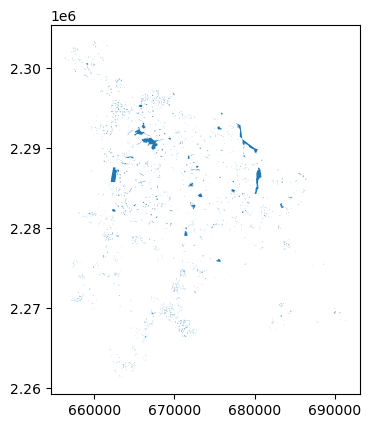

In [11]:
prueba2.plot()

In [13]:
prueba2.tail(5)

,Fuente,Tipo,Uso,geometry,geom_type
8447,"Estatal, SEMADET",Área natural protegida,Uso recreativo,"POLYGON ((677692.000 2293064.000, 677692.000 2...",Polygon
8464,Instrumentos de planeación urbana. Disponible:...,Área natural,Uso recreativo,"POLYGON ((668172.837 2295058.497, 668183.453 2...",Polygon
8465,Instrumentos de planeación urbana. Disponible:...,Área natural,Uso recreativo,"POLYGON ((669994.561 2296682.191, 669995.474 2...",Polygon
8486,Instrumentos de planeación urbana. Disponible:...,Parque,Uso recreativo,"POLYGON ((677652.220 2287758.094, 677672.681 2...",Polygon
8498,Instrumentos de planeación urbana. Disponible:...,Parque,Uso recreativo,"POLYGON ((660386.721 2275524.742, 660374.842 2...",Polygon


In [12]:
prueba2.geometry.get_coordinates()

,x,y
0,672507.0280,2.272132e+06
0,672520.1256,2.272170e+06
0,672562.5524,2.272157e+06
0,672548.5566,2.272119e+06
0,672507.0280,2.272132e+06
...,...,...
8498,660387.7130,2.275550e+06
8498,660393.1728,2.275547e+06
8498,660397.5148,2.275544e+06
8498,660398.9793,2.275543e+06


### Test - Get coordinates (Get vertices from Multipolygons/Polygons ONE BY ONE, slow not used method)

In [9]:
from shapely.geometry import Point

# Show original columns
col = gdf.columns.tolist()
print(col)

# To create new GeoDataFrame with same columns
nodes = gpd.GeoDataFrame(columns=col)

# Extraction of the polygon nodes and attributes values from polys and integration into the new GeoDataFrame
tmp_gdf = gpd.GeoDataFrame()

i = 1 
# For each row (polygon)
for index, row in gdf.iterrows():

    print(f'STARTING row {i}/{len(gdf)}.')

    # If it is a multypolygon, extract polygon, extract vertices
    if row['geom_type'] == 'MultiPolygon':
        
        print(f'Row {i} is MultiPolygon.')
        
        j = 1
        for poly in list(row.geometry.geoms):

            print(f'Starting Polygon {j}/{len(list(row.geometry.geoms))} for row {i}.')
            
            # For each point of polygon
            for coord in list(poly.exterior.coords):
                
                # Add polygon data
                tmp_gdf.loc[0,'Fuente'] = row['Fuente']
                tmp_gdf.loc[0,'Tipo'] = row['Tipo']
                tmp_gdf.loc[0,'Uso'] = row['Uso']

                # Add point data
                tmp_gdf.loc[0,'geometry'] = Point(coord)
                
                # Add to nodes gdf
                nodes = pd.concat([nodes,tmp_gdf],ignore_index=True)

            j = j+1
                
    # If it is a polygon, extract vertices
    else:
        # For each point of polygon
        poly_coords = list(row['geometry'].exterior.coords)
        for coord in poly_coords:
            
            # Add polygon data
            tmp_gdf.loc[0,'Fuente'] = row['Fuente']
            tmp_gdf.loc[0,'Tipo'] = row['Tipo']
            tmp_gdf.loc[0,'Uso'] = row['Uso']
            
            # Add point data
            tmp_gdf.loc[0,'geometry'] = Point(coord)
            
            # Add to nodes gdf
            nodes = pd.concat([nodes,tmp_gdf],ignore_index=True)

    i = i+1
        
print(nodes.shape)
nodes.head(2)

['Fuente', 'Tipo', 'Uso', 'geometry', 'geom_type']
STARTING row 1/8499.
STARTING row 2/8499.
STARTING row 3/8499.
STARTING row 4/8499.
STARTING row 5/8499.
STARTING row 6/8499.
STARTING row 7/8499.
STARTING row 8/8499.
STARTING row 9/8499.
STARTING row 10/8499.
STARTING row 11/8499.
STARTING row 12/8499.
STARTING row 13/8499.
STARTING row 14/8499.
STARTING row 15/8499.
STARTING row 16/8499.
STARTING row 17/8499.
STARTING row 18/8499.
STARTING row 19/8499.
STARTING row 20/8499.
STARTING row 21/8499.
STARTING row 22/8499.
STARTING row 23/8499.
STARTING row 24/8499.
STARTING row 25/8499.
STARTING row 26/8499.
STARTING row 27/8499.
STARTING row 28/8499.
STARTING row 29/8499.
STARTING row 30/8499.
STARTING row 31/8499.
STARTING row 32/8499.
STARTING row 33/8499.
STARTING row 34/8499.
STARTING row 35/8499.
STARTING row 36/8499.
STARTING row 37/8499.
STARTING row 38/8499.
STARTING row 39/8499.
STARTING row 40/8499.
STARTING row 41/8499.
STARTING row 42/8499.
STARTING row 43/8499.
STARTING row

,Fuente,Tipo,Uso,geometry,geom_type
0,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,POINT (672507.028 2272132.201),NaN
1,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,POINT (672520.126 2272170.353),NaN


#### Evaluate result

<Axes: >

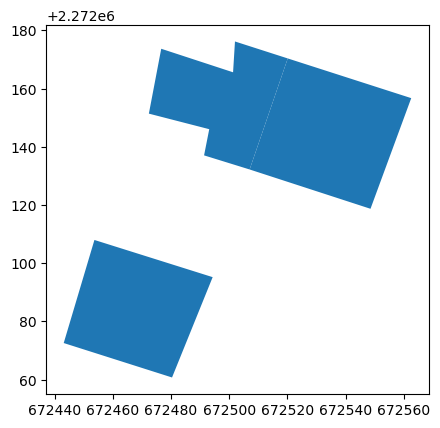

In [37]:
poly_test = gdf.loc[(0,1,2),]
poly_test.plot()

In [38]:
nodes.set_crs("EPSG:32613",inplace=True)
nodes_test = gpd.sjoin(nodes,poly_test)
nodes_test.shape

(28, 10)

In [39]:
nodes_test_f = nodes_test.drop_duplicates()
nodes_test_f.shape

(16, 10)

<Axes: >

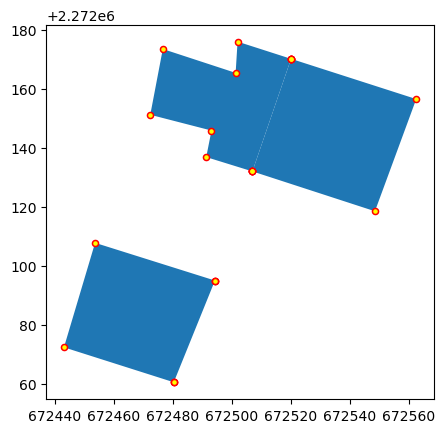

In [40]:
fig,ax=plt.subplots(figsize=(5,5))

poly_test.plot(ax=ax,zorder=0)
nodes_test.plot(ax=ax,zorder=1,c='red',markersize=20)
nodes_test_f.plot(ax=ax,zorder=1,c='yellow',markersize=5)

#### Drop duplicates

In [44]:
nodes.set_crs("EPSG:32613",inplace=True)
nodes_dropdups = nodes.drop_duplicates()
nodes_dropdups['geom_type'] = nodes_dropdups.geom_type

# Show
print(nodes_dropdups.geom_type.unique())
print(nodes_dropdups.shape)
nodes_dropdups.head(2)

['Point']
(266292, 5)


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,Fuente,Tipo,Uso,geometry,geom_type
0,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,POINT (672507.028 2272132.201),Point
1,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,POINT (672520.126 2272170.353),Point


#### Save and last test

In [45]:
save_schema = 'espacios_publicos' 
save_table = 'ep_amg_year_vertices'

aup.gdf_to_db_slow(nodes_dropdups, save_table, save_schema, if_exists='append')

In [46]:
# Test - load parques vertices pois
query = f"SELECT * FROM {save_schema}.{save_table}"
load_test = aup.gdf_from_query(query, geometry_col='geometry')

In [47]:
# Show
print(load_test.crs)
print(load_test.shape)
load_test.head(2)

epsg:32613
(266292, 5)


,Fuente,Tipo,Uso,geometry,geom_type
0,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,POINT (672507.028 2272132.201),Point
1,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,POINT (672520.126 2272170.353),Point


### Test - Get coordinates (Método Edgar)

In [58]:
gdf_coords = gdf.geometry.get_coordinates()
gdf_coords

,x,y
0,672507.0280,2.272132e+06
0,672520.1256,2.272170e+06
0,672562.5524,2.272157e+06
0,672548.5566,2.272119e+06
0,672507.0280,2.272132e+06
...,...,...
8498,660387.7130,2.275550e+06
8498,660393.1728,2.275547e+06
8498,660397.5148,2.275544e+06
8498,660398.9793,2.275543e+06


In [59]:
gdf_coords_data = pd.merge(gdf_coords,gdf,left_index=True,right_index=True)
gdf_coords_data

,x,y,Fuente,Tipo,Uso,geometry,geom_type
0,672507.0280,2.272132e+06,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672507.028 2272132.201, 672520.126 2...",Polygon
0,672520.1256,2.272170e+06,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672507.028 2272132.201, 672520.126 2...",Polygon
0,672562.5524,2.272157e+06,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672507.028 2272132.201, 672520.126 2...",Polygon
0,672548.5566,2.272119e+06,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672507.028 2272132.201, 672520.126 2...",Polygon
0,672507.0280,2.272132e+06,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672507.028 2272132.201, 672520.126 2...",Polygon
...,...,...,...,...,...,...,...
8498,660387.7130,2.275550e+06,Instrumentos de planeación urbana. Disponible:...,Parque,Uso recreativo,"POLYGON ((660386.721 2275524.742, 660374.842 2...",Polygon
8498,660393.1728,2.275547e+06,Instrumentos de planeación urbana. Disponible:...,Parque,Uso recreativo,"POLYGON ((660386.721 2275524.742, 660374.842 2...",Polygon
8498,660397.5148,2.275544e+06,Instrumentos de planeación urbana. Disponible:...,Parque,Uso recreativo,"POLYGON ((660386.721 2275524.742, 660374.842 2...",Polygon
8498,660398.9793,2.275543e+06,Instrumentos de planeación urbana. Disponible:...,Parque,Uso recreativo,"POLYGON ((660386.721 2275524.742, 660374.842 2...",Polygon


In [22]:
gdf_coords.loc[50]

,x,y
50,673531.6494,2.273001e+06
50,673457.5908,2.272994e+06
50,673454.5213,2.273087e+06
50,673453.9416,2.273116e+06
50,673530.6558,2.273115e+06
50,673531.5892,2.273078e+06
50,673531.6494,2.273001e+06


In [25]:
prueba = gdf_coords_data.loc[50]
print(prueba.geometry.unique())
prueba

<GeometryArray>
[<POLYGON ((673531.649 2273001.344, 673457.591 2272994.303, 673454.521 227308...>]
Length: 1, dtype: geometry


,x,y,Fuente,Tipo,Uso,geometry,geom_type
50,673531.6494,2.273001e+06,Instrumentos de planeación urbana. Disponible:...,Unidad deportiva,Uso recreativo,"POLYGON ((673531.649 2273001.344, 673457.591 2...",Polygon
50,673457.5908,2.272994e+06,Instrumentos de planeación urbana. Disponible:...,Unidad deportiva,Uso recreativo,"POLYGON ((673531.649 2273001.344, 673457.591 2...",Polygon
50,673454.5213,2.273087e+06,Instrumentos de planeación urbana. Disponible:...,Unidad deportiva,Uso recreativo,"POLYGON ((673531.649 2273001.344, 673457.591 2...",Polygon
50,673453.9416,2.273116e+06,Instrumentos de planeación urbana. Disponible:...,Unidad deportiva,Uso recreativo,"POLYGON ((673531.649 2273001.344, 673457.591 2...",Polygon
50,673530.6558,2.273115e+06,Instrumentos de planeación urbana. Disponible:...,Unidad deportiva,Uso recreativo,"POLYGON ((673531.649 2273001.344, 673457.591 2...",Polygon
50,673531.5892,2.273078e+06,Instrumentos de planeación urbana. Disponible:...,Unidad deportiva,Uso recreativo,"POLYGON ((673531.649 2273001.344, 673457.591 2...",Polygon
50,673531.6494,2.273001e+06,Instrumentos de planeación urbana. Disponible:...,Unidad deportiva,Uso recreativo,"POLYGON ((673531.649 2273001.344, 673457.591 2...",Polygon


In [27]:
prueba2 = prueba.drop(columns=['geometry'])
prueba2

,x,y,Fuente,Tipo,Uso,geom_type
50,673531.6494,2.273001e+06,Instrumentos de planeación urbana. Disponible:...,Unidad deportiva,Uso recreativo,Polygon
50,673457.5908,2.272994e+06,Instrumentos de planeación urbana. Disponible:...,Unidad deportiva,Uso recreativo,Polygon
50,673454.5213,2.273087e+06,Instrumentos de planeación urbana. Disponible:...,Unidad deportiva,Uso recreativo,Polygon
50,673453.9416,2.273116e+06,Instrumentos de planeación urbana. Disponible:...,Unidad deportiva,Uso recreativo,Polygon
50,673530.6558,2.273115e+06,Instrumentos de planeación urbana. Disponible:...,Unidad deportiva,Uso recreativo,Polygon
50,673531.5892,2.273078e+06,Instrumentos de planeación urbana. Disponible:...,Unidad deportiva,Uso recreativo,Polygon
50,673531.6494,2.273001e+06,Instrumentos de planeación urbana. Disponible:...,Unidad deportiva,Uso recreativo,Polygon


In [56]:
gdf_2 = gpd.GeoDataFrame(prueba2, 
                               geometry=gpd.points_from_xy(prueba2.x, prueba2.y), 
                               crs="EPSG:4326")

gdf_2.drop(columns=['x','y'],inplace=True)
gdf_2.reset_index(inplace=True)
gdf_2.rename(columns={'index':'polygon_id'},inplace=True)

gdf_2

,polygon_id,Fuente,Tipo,Uso,geom_type,geometry
0,50,Instrumentos de planeación urbana. Disponible:...,Unidad deportiva,Uso recreativo,Polygon,POINT (673531.64940 2273001.34380)
1,50,Instrumentos de planeación urbana. Disponible:...,Unidad deportiva,Uso recreativo,Polygon,POINT (673457.59080 2272994.30350)
2,50,Instrumentos de planeación urbana. Disponible:...,Unidad deportiva,Uso recreativo,Polygon,POINT (673454.52130 2273087.27170)
3,50,Instrumentos de planeación urbana. Disponible:...,Unidad deportiva,Uso recreativo,Polygon,POINT (673453.94160 2273116.28150)
4,50,Instrumentos de planeación urbana. Disponible:...,Unidad deportiva,Uso recreativo,Polygon,POINT (673530.65580 2273114.50100)
5,50,Instrumentos de planeación urbana. Disponible:...,Unidad deportiva,Uso recreativo,Polygon,POINT (673531.58920 2273077.61730)
6,50,Instrumentos de planeación urbana. Disponible:...,Unidad deportiva,Uso recreativo,Polygon,POINT (673531.64940 2273001.34380)


<Axes: >

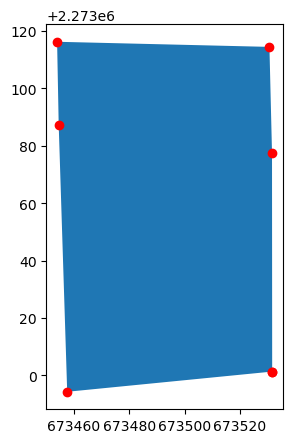

In [57]:
poly_test = gdf.loc[[50],]

fig,ax=plt.subplots(figsize=(5,5))

poly_test.plot(ax=ax,zorder=0)
gdf_2.plot(ax=ax,zorder=1,c='red')

## Convert to function

In [134]:
####################################################################################################################################
# NEW
# Project Volvo includes 'parques', which are in OdC's DB
####################################################################################################################################
def get_parques_pois(parques_schema,parques_table,code):
    # This function creates parques points of interest out of vertices of parques found in db (schema>table)

    # Download parques pois
    query = f"SELECT * FROM {parques_schema}.{parques_table}"
    gdf = aup.gdf_from_query(query, geometry_col='geometry')
    gdf = gdf.to_crs("EPSG:4326")

    # Get vertices coordinates
    gdf_coords = gdf.geometry.get_coordinates()

    # Merge back with gdf containing data
    gdf_coords_data = pd.merge(gdf_coords,gdf,left_index=True,right_index=True)

    # Drop poly geometry 
    df_coords_data = gdf_coords_data.drop(columns=['geometry'])
    # Set points geometry
    gdf_2 = gpd.GeoDataFrame(df_coords_data, 
                             geometry=gpd.points_from_xy(df_coords_data.x, df_coords_data.y),
                             crs='EPSG:4326')
    # Format
    gdf_2.drop(columns=['x','y'],inplace=True)
    gdf_2.reset_index(inplace=True)
    gdf_2.rename(columns={'index':'polygon_id'},inplace=True)

    # Project Volvo filter
    # Tipos
    tipos = ['Parque','Espacio verde vecinal', 'Plaza', 'Área natural', 'Área natural protegida']
    gdf_f1 = gdf_2.loc[gdf_2.Tipo.isin(tipos)]
    # Usos
    gdf_f2 = gdf_f1.loc[gdf_f1.Uso == 'Uso recreativo']

    # Proxanalysis filter
    #code_pois = gdf_f2.set_crs("EPSG:4326")
    gdf_f2['code'] = code
    code_pois = gdf_f2[['polygon_id','code','geometry']]
    code_pois['code'] = code_pois['code'].astype('int64')

    code_pois = code_pois.drop_duplicates()

    return code_pois

In [135]:
code = 9321
code_pois = get_parques_pois(parques_schema,parques_table,code)

# Show
print(code_pois.shape)
code_pois.head(2)

(57635, 3)


/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,polygon_id,code,geometry
0,0,9321,POINT (672507.028 2272132.201)
1,0,9321,POINT (672520.126 2272170.353)


In [136]:
code_pois.tail(2)

,polygon_id,code,geometry
0,0,9321,POINT (672507.028 2272132.201)
1,0,9321,POINT (672520.126 2272170.353)
2,0,9321,POINT (672562.552 2272156.712)
3,0,9321,POINT (672548.557 2272118.695)
5,1,9321,POINT (672520.126 2272170.353)
...,...,...,...
275580,8498,9321,POINT (660386.653 2275550.208)
275581,8498,9321,POINT (660387.713 2275549.734)
275582,8498,9321,POINT (660393.173 2275546.981)
275583,8498,9321,POINT (660397.515 2275544.276)


## Test function

<Axes: >

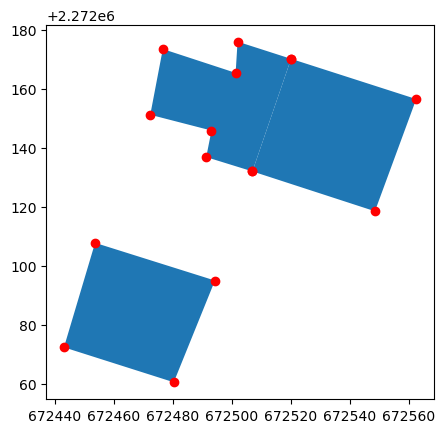

In [141]:
# Filter for three test polygons
poly_test = gdf.loc[(0,1,2),]
vertices_test = code_pois.loc[(code_pois.polygon_id == 0)| (code_pois.polygon_id == 1) | (code_pois.polygon_id == 2)]

# Show (plot)
fig,ax=plt.subplots(figsize=(5,5))
poly_test.plot(ax=ax,zorder=0)
vertices_test.plot(ax=ax,zorder=1,c='red')

In [132]:
vertices_test

,polygon_id,code,geometry
0,0,9321,POINT (672507.028 2272132.201)
1,0,9321,POINT (672520.126 2272170.353)
2,0,9321,POINT (672562.552 2272156.712)
3,0,9321,POINT (672548.557 2272118.695)
5,1,9321,POINT (672520.126 2272170.353)
6,1,9321,POINT (672507.028 2272132.201)
7,1,9321,POINT (672491.377 2272137.047)
8,1,9321,POINT (672493.153 2272146.044)
9,1,9321,POINT (672472.408 2272151.391)
10,1,9321,POINT (672476.656 2272173.677)
